In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH = 'data/'

In [3]:
products = pd.read_csv(f'{PATH}amazon_baby.csv',low_memory=False)

In [4]:
products = products.fillna({'review':''})

In [5]:
def remove_punctuation(text):
    import string
    return text.translate(str.maketrans('', '', string.punctuation)) 

products['review_clean'] = products['review'].apply(remove_punctuation)

In [6]:
products = products[products['rating'] != 3]

In [7]:
products['sentiment'] = products['rating'].apply(lambda rating: +1 if rating > 3 else -1)

In [8]:
import json
f = open(f'{PATH}module-9-assignment-train-idx.json',)
train_ids = json.load(f)
f = open(f'{PATH}module-9-assignment-test-idx.json',)
test_ids = json.load(f)
f.close()

In [9]:
train_data = products.iloc[train_ids]
test_data = products.iloc[test_ids]

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
model = LogisticRegression(max_iter=10000).fit(train_matrix, train_data['sentiment'])

In [13]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'].to_numpy(), y_pred=model.predict(test_matrix))
print("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.9322954163666907


In [14]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


### Using accuracy as the evaluation metric, our logistic regression model is better than the baseline (majority class classifier)

In [15]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print(' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3788
     -1       |        1        |  1453
      1       |       -1        |   804
      1       |        1        | 27291


### 1453 predicted values in the test set are false positives.

In [16]:
1453*100+804*1

146104

### Given the stipluation of a manufacturer selling baby products on amazon, the cost associated with the logistic regression classifier's performance on the test set is $146,104

In [17]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=model.predict(test_matrix))
print("Precision on test data: %s" % precision)

Precision on test data: 0.9494503200667965


### Out of all reviews in the test set that are predicted to be positive, a fraction of 0.05 of them are false positives.

### If we wanted to reduce the perecentage of false positives, we could make our logistic regression model more pessimistic by increasing the threshold probability over which datapoints are predicted to be positive.

In [18]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=model.predict(test_matrix))
print("Recall on test data: %s" % recall)

Recall on test data: 0.9713828083288841


### A fraction of 0.97 of the positive reviews in the test set were correctly predicted as positive by the classifier.

### The recall value of a classifier that predicts +1 for all the datapoints in the test data is 1.

In [19]:
def apply_threshold(probabilities,threshold):
    return probabilities.apply(lambda probability: +1 if probability > threshold else -1)

In [20]:
probabilities = model.predict_proba(test_matrix)[:,1]

In [21]:
(apply_threshold(pd.Series(probabilities),0.5) == 1).sum()

28744

In [22]:
(apply_threshold(pd.Series(probabilities),0.9) == 1).sum()

25068

In [23]:
28744-25068

3676

### No of positive predicted reviews decreases by 3676 as threshold increases from 0.5 to 0.9

### True labels

In [24]:
true_labels = test_data['sentiment']

In [25]:
true_labels

9         1
10        1
16        1
20        1
28        1
         ..
183507    1
183515    1
183522    1
183524    1
183530    1
Name: sentiment, Length: 33336, dtype: int64

### Predicted labels

In [26]:
predicted_labels_high_threshold = (apply_threshold(pd.Series(probabilities,index=true_labels.index),0.9))

In [27]:
predicted_labels_high_threshold

9        -1
10        1
16        1
20        1
28        1
         ..
183507    1
183515    1
183522    1
183524    1
183530    1
Length: 33336, dtype: int64

In [28]:
predicted_labels_low_threshold = (apply_threshold(pd.Series(probabilities,index=true_labels.index),0.5))

In [29]:
predicted_labels_low_threshold

9         1
10        1
16        1
20        1
28        1
         ..
183507    1
183515    1
183522    1
183524    1
183530    1
Length: 33336, dtype: int64

In [30]:
precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=predicted_labels_low_threshold.to_numpy())
print("Precision on test data: %s" % precision)

Precision on test data: 0.9494503200667965


In [31]:
precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=predicted_labels_high_threshold.to_numpy())
print("Precision on test data: %s" % precision)

Precision on test data: 0.9814903462581778


### Precision increased from 0.949 to 0.981 with a higher threshold 

In [32]:
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=predicted_labels_low_threshold.to_numpy())
print("Recall on test data: %s" % recall)

Recall on test data: 0.9713828083288841


In [33]:
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=predicted_labels_high_threshold.to_numpy())
print("Recall on test data: %s" % recall)

Recall on test data: 0.8757430147713117


### Recall decreased from 0.971 to 0.875 with a higher threshold

In [34]:
threshold_values = np.linspace(0.5, 0.99, num=100)
print(threshold_values)

[0.5        0.50494949 0.50989899 0.51484848 0.51979798 0.52474747
 0.52969697 0.53464646 0.53959596 0.54454545 0.54949495 0.55444444
 0.55939394 0.56434343 0.56929293 0.57424242 0.57919192 0.58414141
 0.58909091 0.5940404  0.5989899  0.60393939 0.60888889 0.61383838
 0.61878788 0.62373737 0.62868687 0.63363636 0.63858586 0.64353535
 0.64848485 0.65343434 0.65838384 0.66333333 0.66828283 0.67323232
 0.67818182 0.68313131 0.68808081 0.6930303  0.6979798  0.70292929
 0.70787879 0.71282828 0.71777778 0.72272727 0.72767677 0.73262626
 0.73757576 0.74252525 0.74747475 0.75242424 0.75737374 0.76232323
 0.76727273 0.77222222 0.77717172 0.78212121 0.78707071 0.7920202
 0.7969697  0.80191919 0.80686869 0.81181818 0.81676768 0.82171717
 0.82666667 0.83161616 0.83656566 0.84151515 0.84646465 0.85141414
 0.85636364 0.86131313 0.86626263 0.87121212 0.87616162 0.88111111
 0.88606061 0.8910101  0.8959596  0.90090909 0.90585859 0.91080808
 0.91575758 0.92070707 0.92565657 0.93060606 0.93555556 0.94050

In [35]:
precision_all = []
recall_all = []
for threshold in threshold_values:
    if precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=apply_threshold(pd.Series(probabilities),threshold).to_numpy()) >= 0.965:
        print(threshold)
    precision_all.append(precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=apply_threshold(pd.Series(probabilities),threshold).to_numpy()))
    recall_all.append(recall_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=apply_threshold(pd.Series(probabilities),threshold).to_numpy()))

0.7078787878787879
0.7128282828282828
0.7177777777777777
0.7227272727272727
0.7276767676767677
0.7326262626262626
0.7375757575757576
0.7425252525252525
0.7474747474747474
0.7524242424242424
0.7573737373737374
0.7623232323232323
0.7672727272727273
0.7722222222222221
0.7771717171717172
0.7821212121212121
0.787070707070707
0.7920202020202021
0.7969696969696969
0.8019191919191919
0.8068686868686868
0.8118181818181818
0.8167676767676768
0.8217171717171716
0.8266666666666667
0.8316161616161616
0.8365656565656565
0.8415151515151515
0.8464646464646465
0.8514141414141414
0.8563636363636363
0.8613131313131313
0.8662626262626263
0.8712121212121212
0.8761616161616161
0.8811111111111111
0.886060606060606
0.891010101010101
0.895959595959596
0.9009090909090909
0.9058585858585859
0.9108080808080807
0.9157575757575758
0.9207070707070707
0.9256565656565656
0.9306060606060607
0.9355555555555555
0.9405050505050505
0.9454545454545454
0.9504040404040404
0.9553535353535354
0.9603030303030302
0.96525252525252

In [36]:
precision_all

[0.9494503200667965,
 0.9499582114500627,
 0.9503276631344116,
 0.9509386558727057,
 0.9513549378404805,
 0.9517053396701146,
 0.952152775348886,
 0.9523692867641912,
 0.9528229195853181,
 0.953106928819262,
 0.9536221715488511,
 0.9539790079685471,
 0.9542325254654022,
 0.9545486501687289,
 0.9548668519365392,
 0.9550031687909302,
 0.9553848322526078,
 0.9556629395788508,
 0.9559415378097861,
 0.9564295558146931,
 0.9567416525183927,
 0.9570265486725664,
 0.9575154135071929,
 0.9577704499521328,
 0.9580523812903684,
 0.9584739440872438,
 0.9591067491643553,
 0.9595643197835837,
 0.9599116274097567,
 0.9604666928319121,
 0.9608214285714286,
 0.9610997890521649,
 0.9614627688123949,
 0.9619228427123259,
 0.9623507476065832,
 0.962775504343456,
 0.9629616324184509,
 0.9633747076812377,
 0.9638033495407887,
 0.9641942811812642,
 0.9644430005053787,
 0.9649002313475997,
 0.9651503636955814,
 0.9653011699083632,
 0.9655097377869655,
 0.9657952069716775,
 0.9661805883850322,
 0.9665404500109

In [37]:
recall_all

[0.9713828083288841,
 0.9709556860651362,
 0.9703861897134721,
 0.9699946609717032,
 0.9696743192738921,
 0.9693539775760811,
 0.9689624488343122,
 0.9686065136145221,
 0.9683217654386902,
 0.9679658302189001,
 0.9675387079551522,
 0.9672895533012992,
 0.9669692116034881,
 0.9665420893397402,
 0.9661505605979712,
 0.9654386901583911,
 0.9649403808506851,
 0.9643708844990212,
 0.9638013881473572,
 0.9633742658836092,
 0.9627691760099661,
 0.9623064602242392,
 0.9618437444385122,
 0.9614522156967432,
 0.9608827193450792,
 0.9603844100373732,
 0.9600284748175832,
 0.9595301655098772,
 0.9588182950702973,
 0.9581420181526962,
 0.9575725218010323,
 0.9567894643174942,
 0.9563979355757252,
 0.9558284392240612,
 0.9552945363943762,
 0.9546538529987543,
 0.9540843566470902,
 0.9530877380316782,
 0.9524826481580352,
 0.9517707777184552,
 0.9509521267129383,
 0.9500978821854422,
 0.9492792311799253,
 0.9486029542623242,
 0.9475707421249333,
 0.9467164975974373,
 0.9456842854600462,
 0.9449012279

In [38]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

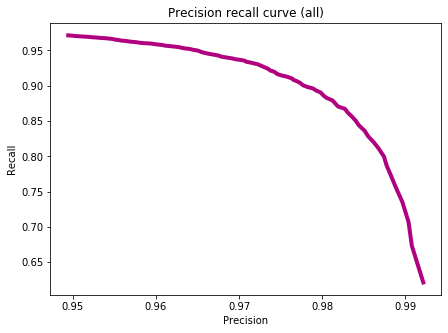

In [39]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

### The smallest threshold value that achieves a precison of greater than 96.5% is 0.708

In [40]:
cmat = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=apply_threshold(pd.Series(probabilities),0.98).to_numpy(),
                        labels=model.classes_)    # use the same order of class as the LR model.
print(' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  5047
     -1       |        1        |   194
      1       |       -1        |  8208
      1       |        1        | 19887


### Using threshold = 0.98, we get 8208 false negatives on the test data

In [41]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in str(x).lower())]

In [44]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

In [46]:
threshold_values = np.linspace(0.5, 0.99, num=100)

In [49]:
precision_all = []
recall_all = []
for threshold in threshold_values:
    if precision_score(y_true=baby_reviews['sentiment'].to_numpy(), 
                            y_pred=apply_threshold(pd.Series(probabilities),threshold).to_numpy()) >= 0.965:
        print(threshold)
    precision_all.append(precision_score(y_true=baby_reviews['sentiment'].to_numpy(), 
                            y_pred=apply_threshold(pd.Series(probabilities),threshold).to_numpy()))
    recall_all.append(recall_score(y_true=baby_reviews['sentiment'].to_numpy(), 
                            y_pred=apply_threshold(pd.Series(probabilities),threshold).to_numpy()))

0.7326262626262626
0.7375757575757576
0.7425252525252525
0.7474747474747474
0.7524242424242424
0.7573737373737374
0.7623232323232323
0.7672727272727273
0.7722222222222221
0.7771717171717172
0.7821212121212121
0.787070707070707
0.7920202020202021
0.7969696969696969
0.8019191919191919
0.8068686868686868
0.8118181818181818
0.8167676767676768
0.8217171717171716
0.8266666666666667
0.8316161616161616
0.8365656565656565
0.8415151515151515
0.8464646464646465
0.8514141414141414
0.8563636363636363
0.8613131313131313
0.8662626262626263
0.8712121212121212
0.8761616161616161
0.8811111111111111
0.886060606060606
0.891010101010101
0.895959595959596
0.9009090909090909
0.9058585858585859
0.9108080808080807
0.9157575757575758
0.9207070707070707
0.9256565656565656
0.9306060606060607
0.9355555555555555
0.9405050505050505
0.9454545454545454
0.9504040404040404
0.9553535353535354
0.9603030303030302
0.9652525252525253
0.9702020202020202
0.9751515151515151
0.9801010101010101
0.985050505050505
0.99


### The smallest threshold value that achieves a precison of greater than 96.5% on baby_reviews is 0.733

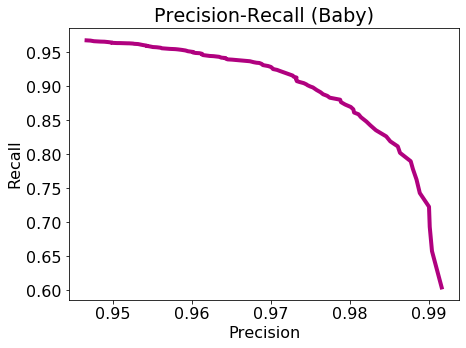

In [50]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")